In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import seaborn as sns
import numpy as np
dcolors = plt.cm.tab10.colors
from pathlib import Path
import statsmodels.formula.api as sm
from scipy.stats import linregress
import scipy.stats as st



In [122]:
git_folder = Path('../../..')
figure_folder = git_folder / 'Figures'

In [123]:
fn = git_folder / 'data' / 'other'/'A_rates_and_values.csv'
df_rates = pd.read_csv(fn, index_col=0)
# df_rates = df_rates.loc[~df_rates['Rate [mmol/gDW/h]'].isna()]

In [124]:
fn_classification = git_folder / 'data'/'this_project'/'5_div'/'5D_classyfire_classification.csv'
df_classyfire = pd.read_csv(fn_classification, index_col=0)
met_to_class = df_classyfire.set_index('Metabolite')['Defined class'].to_dict()

In [125]:
df_rates['Compound class'] = df_rates.Metabolite.map(met_to_class)

In [126]:
df_rates.rename(columns = {'xlogP': 'log P'}, inplace=True)
df_rates['log10(Intracellular conc. [M])'] = np.log10(df_rates['Intracellular concentration [M]'])


In [127]:
df_rates.replace({'Species': {'Ecoli': 'E. coli', 'Pputida': 'P. putida'}}, inplace=True)

# Simple linear model of E. coli in controlled conditions


In [178]:
df_mean = df_rates.groupby(['Carbon source', 'Species', 'Metabolite', 'Dataset']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
df_mean['Compound class'] = df_mean.Metabolite.map(met_to_class)

df_mean.replace([np.inf, -np.inf], np.nan, inplace=True)

df_mean_ecoli = df_mean.loc[(df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')].copy()


In [180]:
df_mean_ecoli.dropna(subset=['Rate [mmol/gDW/h]', 'Metabolite value [gDW/mmol]'], inplace=True)


In [181]:
df_mean_ecoli['Compound class'].unique()

array(['Carboxylic acids', 'Amino acids', 'Keto / hydroxy acids', 'Other',
       'Organooxygen compounds'], dtype=object)

In [266]:
key_to_col = {
    'Y':'log10(Rate [mmol/gDW/h])',
    'A':'log10(Intracellular conc. [M])',
    'B':'log10(Metabolite value [gDW/mmol])',
    'C':'Charge',
    'D':'Mol weight [g/mol]',
    'E':'log P',
    'F':'log10(Turnover [mmol/gDW/h])',
    'R':'Rotatable Bond Count',
    'S':'Hydrogen Bond Donor Count',
    'T':'Hydrogen Bond Acceptor Count',
    'U':'Topological Polar Surface Area',
    'G':'Compound class',
    'H':'Carbon source',
    # 'V':'Simplified class',
}
lindf = pd.DataFrame()
lindf['Y'] = df_mean_ecoli['log10(Rate [mmol/gDW/h])']
lindf['A'] = df_mean_ecoli['log10(Intracellular conc. [M])']
lindf['B'] = df_mean_ecoli['log10(Metabolite value [gDW/mmol])']
lindf['C'] = df_mean_ecoli['Charge']
lindf['D'] = df_mean_ecoli['Mol weight [g/mol]']
lindf['E'] = df_mean_ecoli['log P']
lindf['F'] = df_mean_ecoli['log10(Turnover [mmol/gDW/h])'].copy()
lindf['R'] = df_mean_ecoli['Rotatable Bond Count']
lindf['S'] = df_mean_ecoli['Hydrogen Bond Donor Count']
lindf['T'] = df_mean_ecoli['Hydrogen Bond Acceptor Count']
lindf['U'] = df_mean_ecoli['Topological Polar Surface Area']
lindf['G'] = df_mean_ecoli['Compound class']
lindf['H'] = df_mean_ecoli['Carbon source']
lindf['I'] = df_mean_ecoli['Dataset']

# lindf['V'] = lindf.G.map(simplify_class)
lindf.fillna({'F':-4}, inplace = True)

lindf.dropna(inplace=True)

var_explained = {}
for key, col_name in key_to_col.items():
    if col_name == 'log10(Rate [mmol/gDW/h])':
        continue
    if key not in lindf.columns:
        continue
    res = sm.ols(formula=f"Y ~ {key}", data=lindf).fit()
    var_explained[col_name] = res.rsquared
    print(key, col_name, f'R2: {res.rsquared:.2f}')
    # print(res.summary2())

ols_model =  sm.ols(formula="Y ~ A+B+G+C", data=lindf)
res = ols_model.fit()
var_explained['log10(MV) + log10(IC) + Charge + C class'] = res.rsquared
print(var_explained)
df_r2 = pd.DataFrame(var_explained, index = ['Variability explained']).T.reset_index(names = 'Parameter').sort_values(by= 'Variability explained', ascending = False)

A log10(Intracellular conc. [M]) R2: 0.05
B log10(Metabolite value [gDW/mmol]) R2: 0.43
C Charge R2: 0.04
D Mol weight [g/mol] R2: 0.11
E log P R2: 0.19
F log10(Turnover [mmol/gDW/h]) R2: 0.04
R Rotatable Bond Count R2: 0.19
S Hydrogen Bond Donor Count R2: 0.18
T Hydrogen Bond Acceptor Count R2: 0.05
U Topological Polar Surface Area R2: 0.05
G Compound class R2: 0.29
H Carbon source R2: 0.04
{'log10(Intracellular conc. [M])': np.float64(0.045299912601014514), 'log10(Metabolite value [gDW/mmol])': np.float64(0.4298784611117007), 'Charge': np.float64(0.03593401599726698), 'Mol weight [g/mol]': np.float64(0.11347823733697782), 'log P': np.float64(0.18731011613421622), 'log10(Turnover [mmol/gDW/h])': np.float64(0.04207654819085538), 'Rotatable Bond Count': np.float64(0.1940986877405484), 'Hydrogen Bond Donor Count': np.float64(0.1786975611653263), 'Hydrogen Bond Acceptor Count': np.float64(0.045831775287176746), 'Topological Polar Surface Area': np.float64(0.053453413238113145), 'Compound 

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_83401/1180994233.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data = df_r2, x = 'Variability explained', y = 'Parameter', palette='tab10', ax = ax)


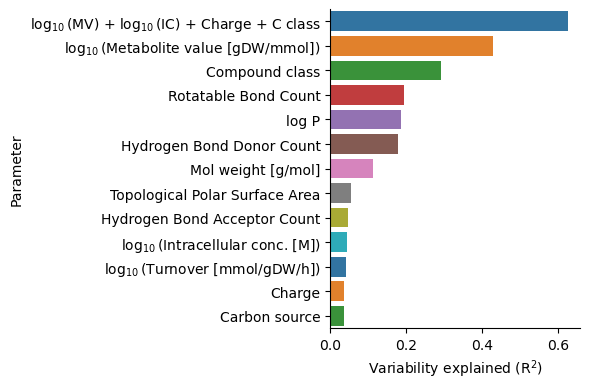

In [267]:

fig, ax = plt.subplots(1, figsize = (6,4))
# ax.barh(y = np.arange(i+1), width = r_squared_list)
# ax.set_yticks(np.arange(i+1), x_axis_list)
# df_r2 = pd.DataFrame()
# df_r2['R2'] = r_squared_list
# df_r2['Parameter'] = x_axis_list
# df_r2.sort_values('R2', inplace=True, ascending=False)

# Replace 'log10' in the 'Parameter' column with LaTeX-style formatting
df_r2['Parameter'] = df_r2['Parameter'].str.replace('log10', r'$\log_{10}$', regex=False)

g = sns.barplot(data = df_r2, x = 'Variability explained', y = 'Parameter', palette='tab10', ax = ax)

                # order = [df_r2.Parameter[1:]+df_r2.Parameter[0]])#, hue_order= df_r2.Parameter)#
# g.set_xticks([0, 0.1, 0.2, 0.3,0.4])
sns.despine()
ax.set_xlabel(r"Variability explained ($\rm{R^2}$)")
# ax.set_ylim(0,0.5)
plt.tight_layout()
plt.savefig(figure_folder / "Variability_explained_ecoli_std.pdf")

In [184]:
st.pearsonr(lindf['B'], lindf['Y'])
st.pearsonr(lindf['B'], lindf['U'])


PearsonRResult(statistic=np.float64(0.32635759866695324), pvalue=np.float64(0.001498779040498903))

log10(Metabolite value [gDW/mmol])
Rotatable Bond Count
log P
Hydrogen Bond Donor Count
Mol weight [g/mol]
Topological Polar Surface Area
Hydrogen Bond Acceptor Count
log10(Intracellular conc. [M])
log10(Turnover [mmol/gDW/h])
Charge


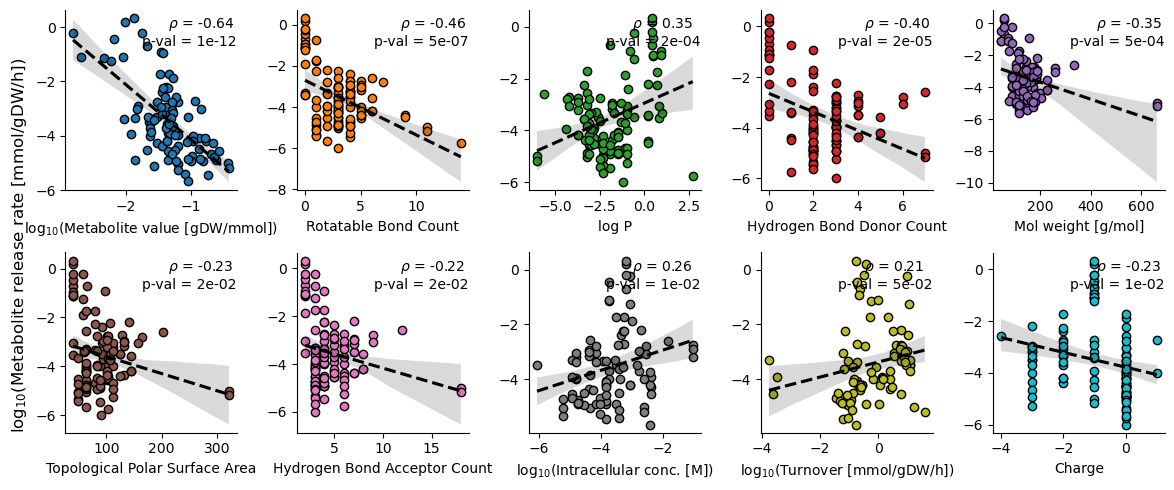

In [185]:

fig, axes = plt.subplots(2,5, figsize = (12,5))#,sharey=True)
axes = axes.flatten()

color_dict = {xaxis:f'C{i}' for i, xaxis in enumerate(df_r2.Parameter)}
bar_colors = [color_dict[x] for x in df_r2.Parameter.values]

number_cols = df_mean.select_dtypes(include='number')
plot_parameters = [x for x in df_r2.Parameter if x in number_cols]

for i, xaxis in enumerate(plot_parameters):
    ax = axes[i]
    print(xaxis)
    idx = (df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')&df_mean[[xaxis,'log10(Rate [mmol/gDW/h])']].notna().all(axis = 1)

    sns.regplot(data = df_mean.loc[idx], x = xaxis, y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': bar_colors[i], 'edgecolor': 'k', 'alpha':1}, ax = ax)
    ax.set_xlabel(xaxis)
    ax.set_ylabel("")

    slope, intercept, rvalue, pvalue, _ = linregress(df_mean.loc[idx, xaxis].values, df_mean.loc[idx, 'log10(Rate [mmol/gDW/h])'].values)
    ax.annotate(fr'$\rho$ = {rvalue:.2f}', (0.6, 0.9), xycoords = 'axes fraction')
    ax.annotate(fr'p-val = {pvalue:.0e}', (0.45, 0.8), xycoords = 'axes fraction')
    ax.set_xlabel(ax.get_xlabel().replace('log10', r'$\rm{log_{10}}$'),size = 10)
    # ax.annotate(fr'$R^2$ = {rvalue**2:.2f}', (0.62, 0.7), xycoords = 'axes fraction')
    
fig.supylabel(r'$\rm{log_{10}}$(Metabolite release rate [mmol/gDW/h])', size = 12)
# axes[-2].remove()
# axes[-1].remove()
plt.tight_layout()
sns.despine()
plt.savefig(figure_folder/'correlations_different_factors_ecoli_standards.pdf')
# corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']]
# corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

## Supplemental linear models for each dataset / species

In [186]:
df_lm_dict = {}
for d in df_mean.Dataset.unique():
    dfd = df_mean.loc[df_mean.Dataset==d]
    for s in dfd.Species.unique():
        if s == 'C. glutamicum':
            continue
        dfs = dfd.loc[dfd.Species==s].copy()
        dfs.fillna({'log10(Turnover [mmol/gDW/h])':-4}, inplace = True)
        dfs.dropna(inplace=True)

        # lindf = pd.DataFrame()
        # lindf['Y'] = df_mean_ecoli['log10(Rate [mmol/gDW/h])']
        # lindf['A'] = df_mean_ecoli['log10(Intracellular conc. [M])']
        # lindf['B'] = df_mean_ecoli['log10(Metabolite value [gDW/mmol])']
        # lindf['C'] = df_mean_ecoli['Charge']
        # lindf['D'] = df_mean_ecoli['Mol weight [g/mol]']
        # lindf['E'] = df_mean_ecoli['log P']
        # lindf['F'] = df_mean_ecoli['log10(Turnover [mmol/gDW/h])'].copy()
        # lindf['R'] = df_mean_ecoli['Rotatable Bond Count']
        # lindf['S'] = df_mean_ecoli['Hydrogen Bond Donor Count']
        # lindf['T'] = df_mean_ecoli['Hydrogen Bond Acceptor Count']
        # lindf['U'] = df_mean_ecoli['Topological Polar Surface Area']
        # lindf['G'] = df_mean_ecoli['Compound class']
        # lindf['H'] = df_mean_ecoli['Carbon source']
        # lindf['I'] = df_mean_ecoli['Dataset']
        lindfd = pd.DataFrame()
        for key, col_name in key_to_col.items():
            lindfd[key] = dfs[col_name]

        var_explained = {}
        for key, col_name in key_to_col.items():
            if col_name == 'log10(Rate [mmol/gDW/h])':
                continue
            elif (col_name=='log10(Intracellular conc. [M])') and (s != 'E. coli'):
                continue
            if col_name not in dfd.columns:
                continue
            res = sm.ols(formula=f"Y ~ {key}", data=lindfd).fit()
            var_explained[col_name] = res.rsquared
            print(key, col_name, f'R2: {res.rsquared:.2f}')
            # print(res.summary2())


        # var_explained['log10(MV) + log10(IC) + Charge + C class'] = res.rsquared
        print(var_explained)
        df_r2 = pd.DataFrame(var_explained, index = ['Variability explained']).T.reset_index(names = 'Parameter').sort_values(by= 'Variability explained', ascending = False)
        df_lm_dict[f'{d}: {s}'] = df_r2
    

B log10(Metabolite value [gDW/mmol]) R2: 0.49
C Charge R2: 0.02
D Mol weight [g/mol] R2: 0.14
E log P R2: 0.00
F log10(Turnover [mmol/gDW/h]) R2: 0.01
R Rotatable Bond Count R2: 0.06
S Hydrogen Bond Donor Count R2: 0.01
T Hydrogen Bond Acceptor Count R2: 0.09
U Topological Polar Surface Area R2: 0.12
G Compound class R2: 0.12
H Carbon source R2: 0.34
{'log10(Metabolite value [gDW/mmol])': np.float64(0.49223782054502074), 'Charge': np.float64(0.023459010805354064), 'Mol weight [g/mol]': np.float64(0.14422258248681574), 'log P': np.float64(0.0046978784299961385), 'log10(Turnover [mmol/gDW/h])': np.float64(0.005799808375877791), 'Rotatable Bond Count': np.float64(0.06373355493592536), 'Hydrogen Bond Donor Count': np.float64(0.009725294939791351), 'Hydrogen Bond Acceptor Count': np.float64(0.09389033968769567), 'Topological Polar Surface Area': np.float64(0.11776780091541272), 'Compound class': np.float64(0.11977951000269116), 'Carbon source': np.float64(0.3359547835196295)}
B log10(Metabo

Text(0, 0.5, '')

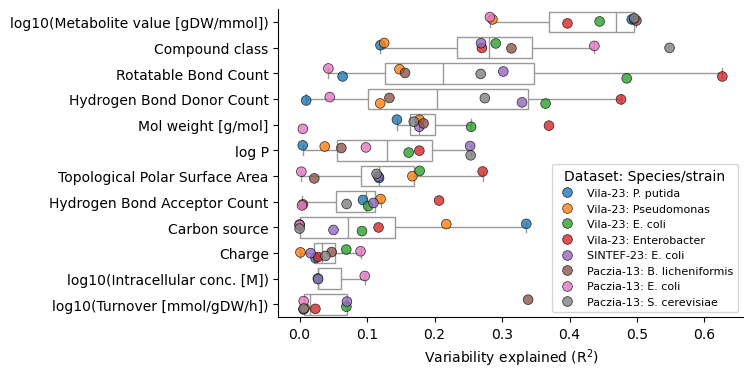

In [264]:
# Calculate the median of 'Variability explained' for each 'Parameter'
median_order = big_df_r2.groupby('Parameter')['Variability explained'].median().sort_values(ascending=False)

# Reorder the DataFrame based on the median order
big_df_r2['Parameter'] = pd.Categorical(big_df_r2['Parameter'])

# Create the plot
fig, ax = plt.subplots(1, figsize=(6, 4))
ax = sns.boxplot(data=big_df_r2, x='Variability explained', y='Parameter',
                 color='w', fliersize=0, order=median_order.index)
sns.stripplot(data=big_df_r2, x='Variability explained', y='Parameter', hue='level_0',
              palette='tab10', legend=True, ax=ax, jitter=0.2, s=7, alpha=0.8, edgecolor='k', linewidth=0.5)

# Format the y-axis labels
# formatted_labels = [label.replace('log10', r'$\log_{10}$') for label in median_order.index]
# ax.set_yticklabels(formatted_labels, fontsize=10)

# Adjust legend
sns.despine()
ax.set_xlabel(r"Variability explained ($\rm{R^2}$)")

sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 0), title='Dataset: Species/strain', fontsize=8)
plt.ylabel('')
# plt.tight_layout()

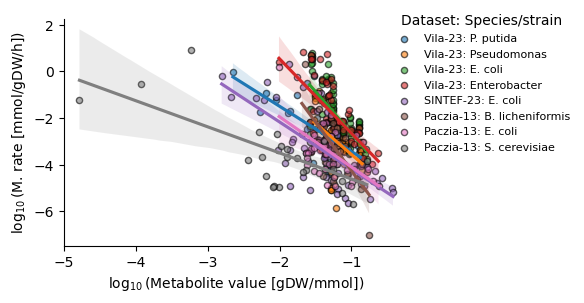

In [262]:
# Combine 'Dataset' and 'Species' into a single column
df_mean['Hue'] = df_mean['Dataset'] + ": " + df_mean['Species']

# Create the plot with the combined column as hue
g = sns.lmplot(
    data=df_mean.loc[df_mean.Species != 'C. glutamicum'],
    x='log10(Metabolite value [gDW/mmol])',
    y='log10(Rate [mmol/gDW/h])',
    hue='Hue',  # Use the combined column for hue
    palette='tab10',
    height=3,
    aspect=1.5,
    scatter_kws={'s': 20, 'edgecolor': 'k', 'alpha': 0.6},
)
sns.move_legend(g, "upper right", bbox_to_anchor=(0.9, 1), title='Dataset: Species/strain', fontsize=8)
plt.xlabel(r'$\log_{10}$(Metabolite value [gDW/mmol])')
plt.ylabel(r'$\log_{10}$(M. rate [mmol/gDW/h])')
plt.savefig(figure_folder / 'MV_vs_rate_all_species.pdf')

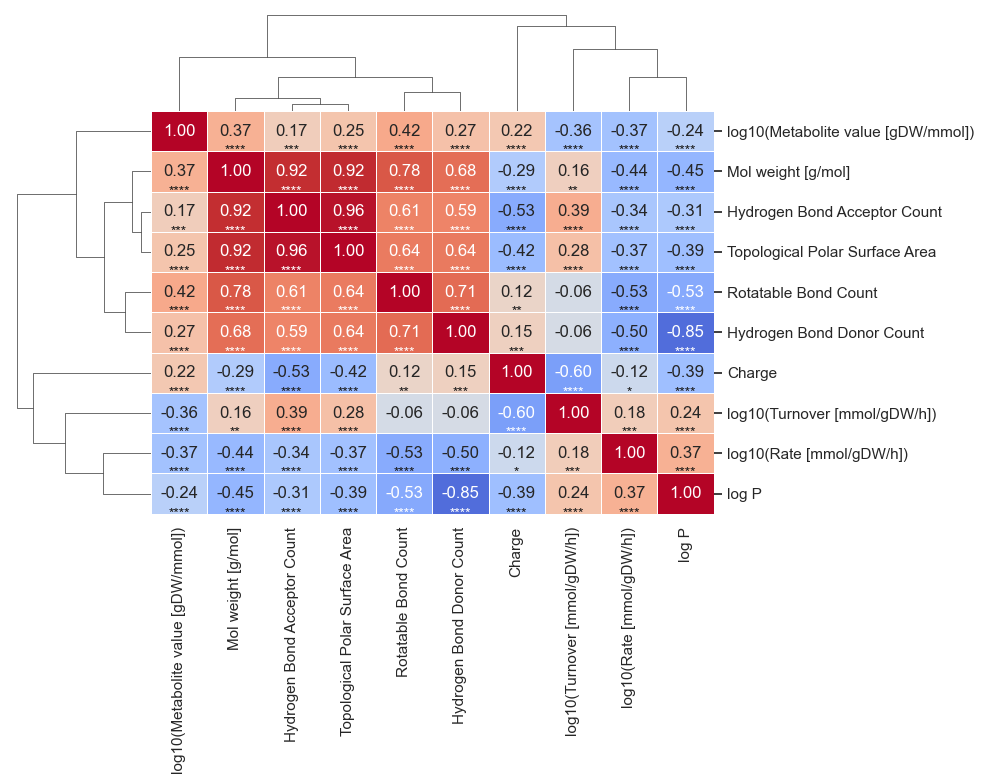

In [331]:
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows where the species is 'C. glutamicum'
cols = [x for x in key_to_col.values() if x not in ['log10(Intracellular conc. [M])']]
df_filtered = df_mean.loc[df_mean['Species'] != 'C. glutamicum', cols]

# Select only numeric columns for correlation
numeric_cols = df_filtered.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix and p-values
correlation_matrix = numeric_cols.corr()
p_values = numeric_cols.corr(method=lambda x, y: pearsonr(x, y)[1])  # Compute p-values for correlations

# Create a mask for significant correlations (e.g., p < 0.05)
significance_mask = p_values < 0.05

# Create the clustermap
sns.set_theme(style="white")
clustermap = sns.clustermap(
    correlation_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,  # Add correlation values to the heatmap
    fmt=".2f",   # Format for annotations
    linewidths=0.5,
    figsize=(10, 8),
    cbar_pos=None
)

# Get the reordered indices from the clustermap
reordered_rows = clustermap.dendrogram_row.reordered_ind
reordered_cols = clustermap.dendrogram_col.reordered_ind

# Reorder the correlation matrix and p-values to match the clustermap
reordered_corr = correlation_matrix.iloc[reordered_rows, reordered_cols]
reordered_pvals = p_values.iloc[reordered_rows, reordered_cols]

# Add stars for significant correlations
for i in range(reordered_corr.shape[0]):
    for j in range(reordered_corr.shape[1]):
        # print(i, j, p_values.iloc[i, j]) 
        if i == j:
            continue
        if reordered_pvals.iloc[i, j] > 0.05:  # Adjust the threshold as needed
            text = ''
        elif 0.01 < reordered_pvals.iloc[i, j] < 0.05:
            text = '*'
        elif 0.001 < reordered_pvals.iloc[i, j] < 0.01:
            text = '**'
        elif 0.0001 < reordered_pvals.iloc[i, j] < 0.001:
            text = '***'
        else:
            text = '****'

        value = reordered_corr.iloc[i, j]

        # Determine the color of the annotation based on the correlation value
        if np.abs(value) > 0.5282:
            color = 'w'
        else:
            color = 'k'

        # Add the annotation at the correct position
        clustermap.ax_heatmap.text(
            j+0.5, i+1, text, color=color, ha='center', va='center', fontsize=10
        )

plt.savefig(figure_folder / 'clustermap_correlations_with_significance.pdf')
# Show the plot
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [286]:
p_values.iloc[1,0]

np.float64(3.0939962016365884e-14)

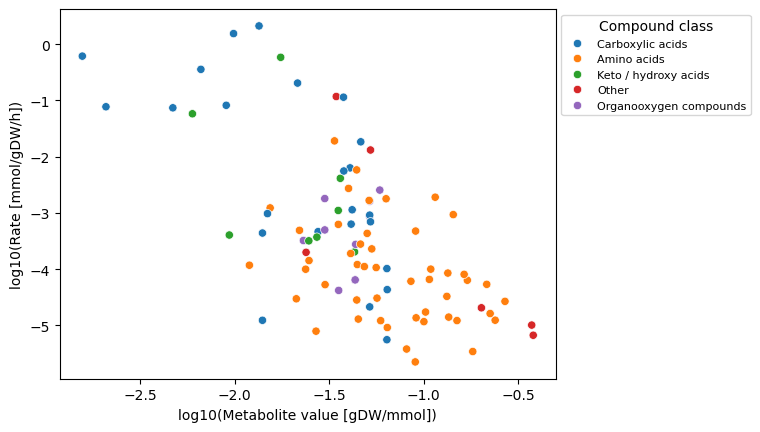

In [188]:
ax = sns.scatterplot(data = df_mean_ecoli, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', hue = 'Compound class')
sns.move_legend(ax, loc  ='upper left', bbox_to_anchor=(1, 1), title = 'Compound class', fontsize = 8)

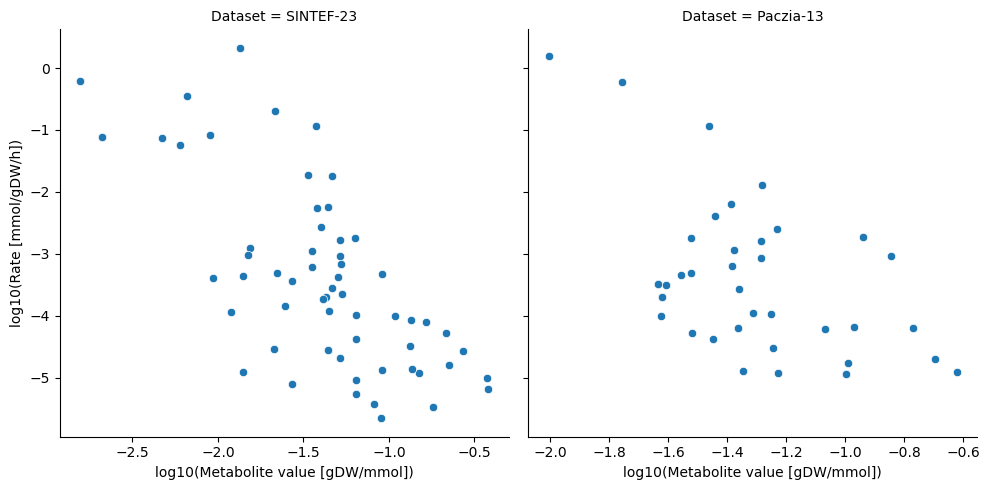

In [189]:
fig = sns.relplot(data = df_mean_ecoli, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Dataset', 
                  facet_kws={'sharey': True, 'sharex': False})
# sns.move_legend(ax, loc  ='upper left', bbox_to_anchor=(1, 1), title = 'Compound class', fontsize = 8)